Here we use value function iteration to solve the finite horizon deterministic consumption - savings problem discussed in class. 
To make our life a bit more simple we will change the notation slightly. 

The problem is 


$$v_{t}\left(a\right)= \max_{c,a'}u\left(c\right)+\beta v_{t+1}\left(a'\right)$$
subject to 

$$ c_{t}=y_{t}+\left(1+r\right)a-a'$$

and 
$$a'   \geq \underline{a} $$

for $t\in\left\{1,2,...,T\right\}$. 

So the difference here is that the initial period is $t=1$, instead of $t=0$.



In [1]:
using Plots 
using Parameters


In [2]:
Household = @with_kw (r = 0.03,                 
                      σ = 1.0,
                      β = 0.97,
                      T = 40,
                      y = ones(T,1),
                      a0 = 0.0,
                      u = σ == 1 ? x -> log(x) : x -> (x^(1 - σ) - 1) / (1 - σ)
					  )

##NamedTuple_kw#291 (generic function with 2 methods)

In [6]:
# create a household that we will play with
ret_age = 25
replacement = 0.25

T = 35

y_level = 1
y_peak  = 1.7
y_path  = zeros(T,)
y_path[1:ret_age+1,1]  = y_level * ones(ret_age+1,1) + LinRange(0,(y_peak-1),ret_age+1)
y_path[ret_age+2:end,1] .= replacement * y_path[ret_age+1,1]
hh_1    = Household(T=T,y=y_path,r = 0.02)

(r = 0.02, σ = 1.0, β = 0.97, T = 35, y = [1.0, 1.028, 1.056, 1.084, 1.112, 1.14, 1.168, 1.196, 1.224, 1.252  …  1.7, 0.425, 0.425, 0.425, 0.425, 0.425, 0.425, 0.425, 0.425, 0.425], a0 = 0.0, u = var"#12#16"())

In [3]:
function grid_vfi_finite(;N=1000,a_min=0.0,a_max=15.0)
# this function creates a grid
a_grid = collect(range(a_min, stop = a_max, length = N))
return a_grid
end

a_grid=grid_vfi_finite();

In [4]:
function vfi_finite(hh,a_grid)

# this is the key function here, it solves the cons.-sav. problem 
T = hh.T

N      = length(a_grid);
V      = Matrix{Float64}(undef, N, T);
A′     = Matrix{Float64}(undef, N, T);
A′_ind = Matrix{Int}(undef, N, T);
C      = Matrix{Float64}(undef, N, T);
c_temp = Matrix{Float64}(undef, N, 1);
w_temp = Matrix{Float64}(undef, N, 1);
u_temp = Matrix{Float64}(undef, N, 1);

# final period - consume everything you have!

C[:,T]  .= (1+hh.r) * a_grid .+ hh.y[T]
V[:,T]  .= hh.u.(C[:,T])
A′[:,T] .= 0.0
A′_ind[:,T] .= 0
# start iteration
for t = (T-1):-1:1
    
    # for each grid point today...
    for ia in eachindex(a_grid)
       
        #... consider each possible grid point tomorrow
        for ia′ in eachindex(a_grid)
            if (1+hh.r) * a_grid[ia] + hh.y[t] - a_grid[ia′] < 1e-10
                c_temp[ia′] = 1e-10  # if consumption is negative, set to a very small number
                u_temp[ia′] = -Inf  # calculate utility
            else
                c_temp[ia′] = (1+hh.r) * a_grid[ia] + hh.y[t] - a_grid[ia′]
                u_temp[ia′] = hh.u(c_temp[ia′])  # calculate utility
            end
            
            w_temp[ia′] = u_temp[ia′] + hh.β * V[ia′,t+1] # calulate utility + continuation value
        end

        V[ia,t], ia′_opt    = findmax(w_temp[:])  # find optimum - stores Value und policy (index of optimal choice)
		A′[ia,t]            = a_grid[ia′_opt]  # record optimal assets tomorrow
        A′_ind[ia,t]        = ia′_opt 
        C[ia,t]             = c_temp[ia′_opt]  # record optinal consumption
    end

end
return V, C, A′, A′_ind
end


vfi_finite (generic function with 1 method)

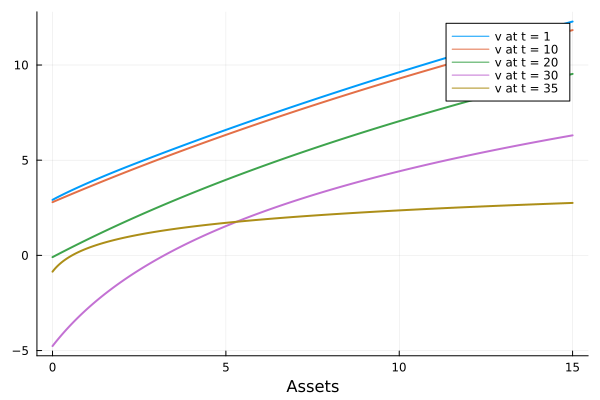

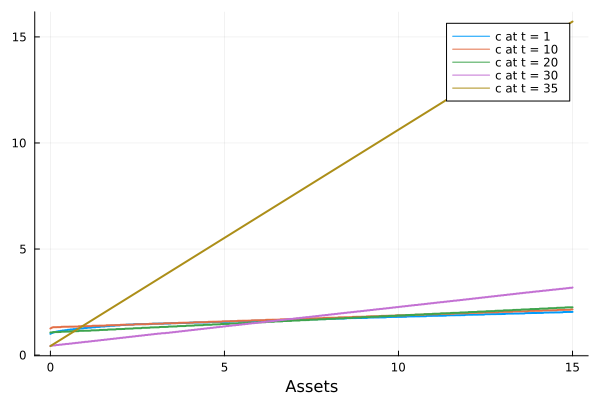

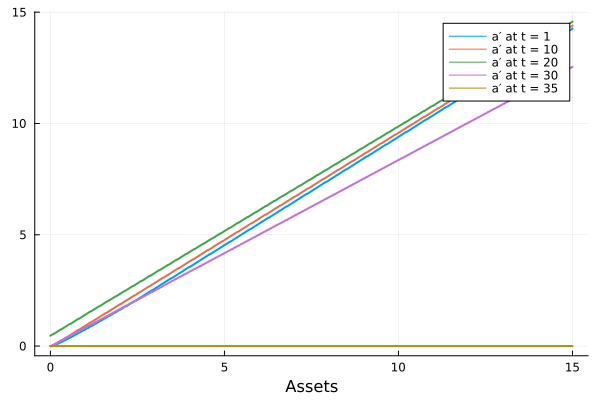

In [8]:
# solve the problem for our household
V, C, A′, A′_ind = vfi_finite(hh_1,a_grid)

# plot the solution
value_plot        = plot(xlabel = "Assets") 
consumption_plot  = plot(xlabel = "Assets")
assets_plot       = plot(xlabel = "Assets")

age_vec = [1,10,20,30,T]

for i in eachindex(age_vec)
    t = age_vec[i]
plot!(assets_plot, a_grid, A′[:,t],labels="a′ at t = $t", lw = 2)
plot!(consumption_plot, a_grid,   C[:,t],labels="c at t = $t", lw = 2)
plot!(value_plot, a_grid,  V[:,t],labels="v at t = $t", lw = 2)
end

display(value_plot)
display(consumption_plot)
display(assets_plot)

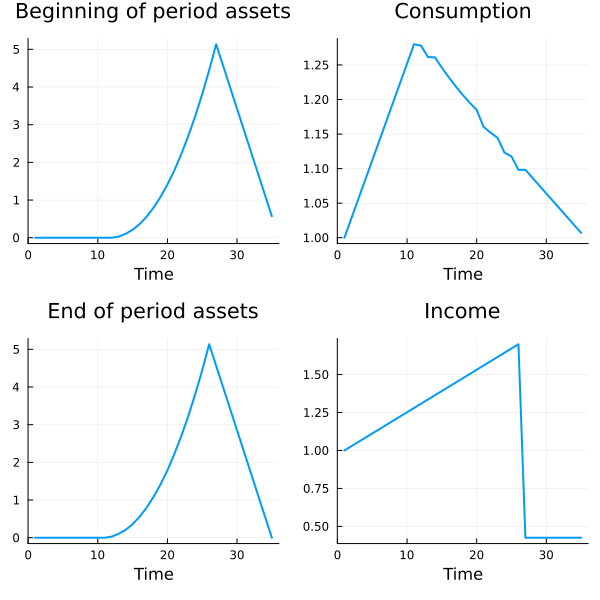

In [9]:

function get_paths(hh,A,A′_ind,C)
# this function find the optimal paths
findnearest(A,x) = argmin(abs.(A .- x))
T = hh.T
ia′ = findnearest(a_grid,hh.a0)
a_path = Array{Float64}(undef,T)
c_path = Array{Float64}(undef,T)
a′_path = Array{Float64}(undef,T)

for t = 1:T 
   ia         = ia′
   a_path[t]  = a_grid[ia] 
   c_path[t]  = C[ia,t]  
   a′_path[t] = A′[ia,t]  
   ia′        = A′_ind[ia,t]
end

return a_path, c_path, a′_path
end


# get those paths and plot them

a_path, c_path, a′_path = get_paths(hh_1,A′,A′_ind,C)
asset_path_plot = plot(1:T,a_path,label=false, lw = 2, title = "Beginning of period assets", xlabel = "Time")
cons_path_plot = plot(1:T,c_path,label=false, lw = 2, title = "Consumption", xlabel = "Time")
asset_next_path_plot = plot(1:T,a′_path,label=false, lw = 2, title = "End of period assets", xlabel = "Time")
income_path_plot = plot(1:T,hh_1.y,label=false, lw = 2, title = "Income", xlabel = "Time")


plot(asset_path_plot,cons_path_plot,asset_next_path_plot,income_path_plot,layout=(2,2),size=(600,600))

In [ ]:
for (ia,achoice) in enumerate(a_grid)
    println(ia)
end